# Exercise 2: Customer Segmentation Classification Using KNN and SVC

Train and fine-tune KNN and SVC classification models for segmenting customers in this dataset from Kaggle. Make sure you iterate on the complete machine learning cycle (data understanding, data preprocessing/cleaning, feature engineering, training and evaluating models, hyper-parameter tuning) to get the best possible performance.

* https://www.kaggle.com/datasets/kaushiksuresh147/customer-segmentation/data

## Pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
df1 = pd.read_csv('./customer-segmentation/Train.csv')
print(df1.shape)
df1.head()

(8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Normalize categorical - ordinal data

In [4]:
df1['Profession'].unique()

array(['Healthcare', 'Engineer', 'Lawyer', 'Entertainment', 'Artist',
       'Executive', 'Doctor', 'Homemaker', 'Marketing', nan], dtype=object)

In [5]:
df1['Work_Experience'].unique()

array([ 1., nan,  0.,  4.,  9., 12.,  3., 13.,  5.,  8., 14.,  7.,  2.,
        6., 10., 11.])

In [6]:
df1['Spending_Score'].unique()

array(['Low', 'Average', 'High'], dtype=object)

In [7]:
df1['Var_1'].unique()

array(['Cat_4', 'Cat_6', 'Cat_7', 'Cat_3', 'Cat_1', 'Cat_2', nan, 'Cat_5'],
      dtype=object)

In [8]:
df1['Segmentation'].unique()

array(['D', 'A', 'B', 'C'], dtype=object)

In [9]:
def replace_spending_score(score):
    if score == 'Low':
        return 0
    elif score == 'Average':
        return 1
    elif score == 'High':
        return 2
    
def replace_var_1(var):
    if var == 'Cat_1':
        return 1
    elif var == 'Cat_2':
        return 2
    elif var == 'Cat_3':
        return 3
    elif var == 'Cat_4':
        return 4
    elif var == 'Cat_5':
        return 5
    elif var == 'Cat_6':
        return 6
    elif var == 'Cat_7':
        return 7

def replace_segmentation(seg):
    if seg == 'A':
        return 1
    elif seg == 'B':
        return 2
    elif seg == 'C':
        return 3
    elif seg == 'D':
        return 4

df2 = df1.copy()
df2['Ever_Married'] = df1['Ever_Married'].apply(lambda x: 0 if x == 'No' else 1)
df2['Graduated'] = df1['Graduated'].apply(lambda x: 0 if x == 'No' else 1)
df2['Spending_Score'] = df1['Spending_Score'].apply(replace_spending_score)
df2['Var_1'] = df1['Var_1'].apply(replace_var_1)
df2['Segmentation'] = df1['Segmentation'].apply(replace_segmentation)

df2.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,0,22,0,Healthcare,1.0,0,4.0,4.0,4
1,462643,Female,1,38,1,Engineer,NaN,1,3.0,4.0,1
2,466315,Female,1,67,1,Engineer,1.0,0,1.0,6.0,2
3,461735,Male,1,67,1,Lawyer,0.0,2,2.0,6.0,2
4,462669,Female,1,40,1,Entertainment,NaN,2,6.0,6.0,1


In [10]:
gender_encoded = pd.get_dummies(df2['Gender'], dtype='int8')

df3 = pd.concat([
    df2.drop('Gender', axis=1),
    gender_encoded
], axis=1)
df3.head()

,ID,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Female,Male
0,462809,0,22,0,Healthcare,1.0,0,4.0,4.0,4,0,1
1,462643,1,38,1,Engineer,NaN,1,3.0,4.0,1,1,0
2,466315,1,67,1,Engineer,1.0,0,1.0,6.0,2,1,0
3,461735,1,67,1,Lawyer,0.0,2,2.0,6.0,2,0,1
4,462669,1,40,1,Entertainment,NaN,2,6.0,6.0,1,1,0


Normalize Profession categorical - nominal data

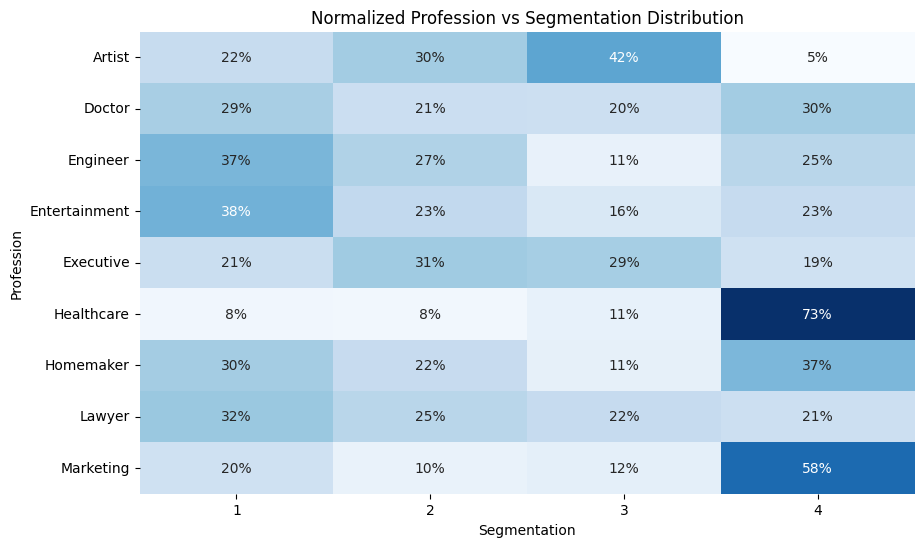

In [11]:
contingency_table = pd.crosstab(df3['Profession'], df3['Segmentation'])

plt.figure(figsize=(10,6))
sns.heatmap(contingency_table.div(contingency_table.sum(1), axis=0), 
            annot=True, fmt=".0%", cmap="Blues", cbar=False)
plt.title("Normalized Profession vs Segmentation Distribution")
plt.ylabel("Profession")
plt.xlabel("Segmentation")
plt.show()

In [12]:
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

correlation = cramers_v(contingency_table)
print(f"\nCramer's V correlation between Profession and Segmentation: {correlation:.3f}")


Cramer's V correlation between Profession and Segmentation: 0.334


> It represents a __moderate__ association

In [13]:
profession_encoded = pd.get_dummies(df3['Profession'], prefix='', dummy_na=True, dtype='int8')
profession_encoded = profession_encoded.rename(
    columns={'_nan': 'No_Profession'}
)

df4 = pd.concat([
    df3.drop('Profession', axis=1),
    profession_encoded
], axis=1)
df4.head()

,ID,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Female,...,_Artist,_Doctor,_Engineer,_Entertainment,_Executive,_Healthcare,_Homemaker,_Lawyer,_Marketing,No_Profession
0,462809,0,22,0,1.0,0,4.0,4.0,4,0,...,0,0,0,0,0,1,0,0,0,0
1,462643,1,38,1,NaN,1,3.0,4.0,1,1,...,0,0,1,0,0,0,0,0,0,0
2,466315,1,67,1,1.0,0,1.0,6.0,2,1,...,0,0,1,0,0,0,0,0,0,0
3,461735,1,67,1,0.0,2,2.0,6.0,2,0,...,0,0,0,0,0,0,0,1,0,0
4,462669,1,40,1,NaN,2,6.0,6.0,1,1,...,0,0,0,1,0,0,0,0,0,0


Check the correlation with the target attribute

In [14]:
def draw_correlation_table(df):
    corr_matrix = df.corr(numeric_only=True)

    plt.figure(figsize=(16, 15))
    sns.heatmap(corr_matrix, 
                annot=True, 
                cmap='coolwarm', 
                vmin=-1, 
                vmax=1, 
                center=0,
                fmt='.2f',
                linewidths=0.5,
                linecolor='black')
    plt.show()

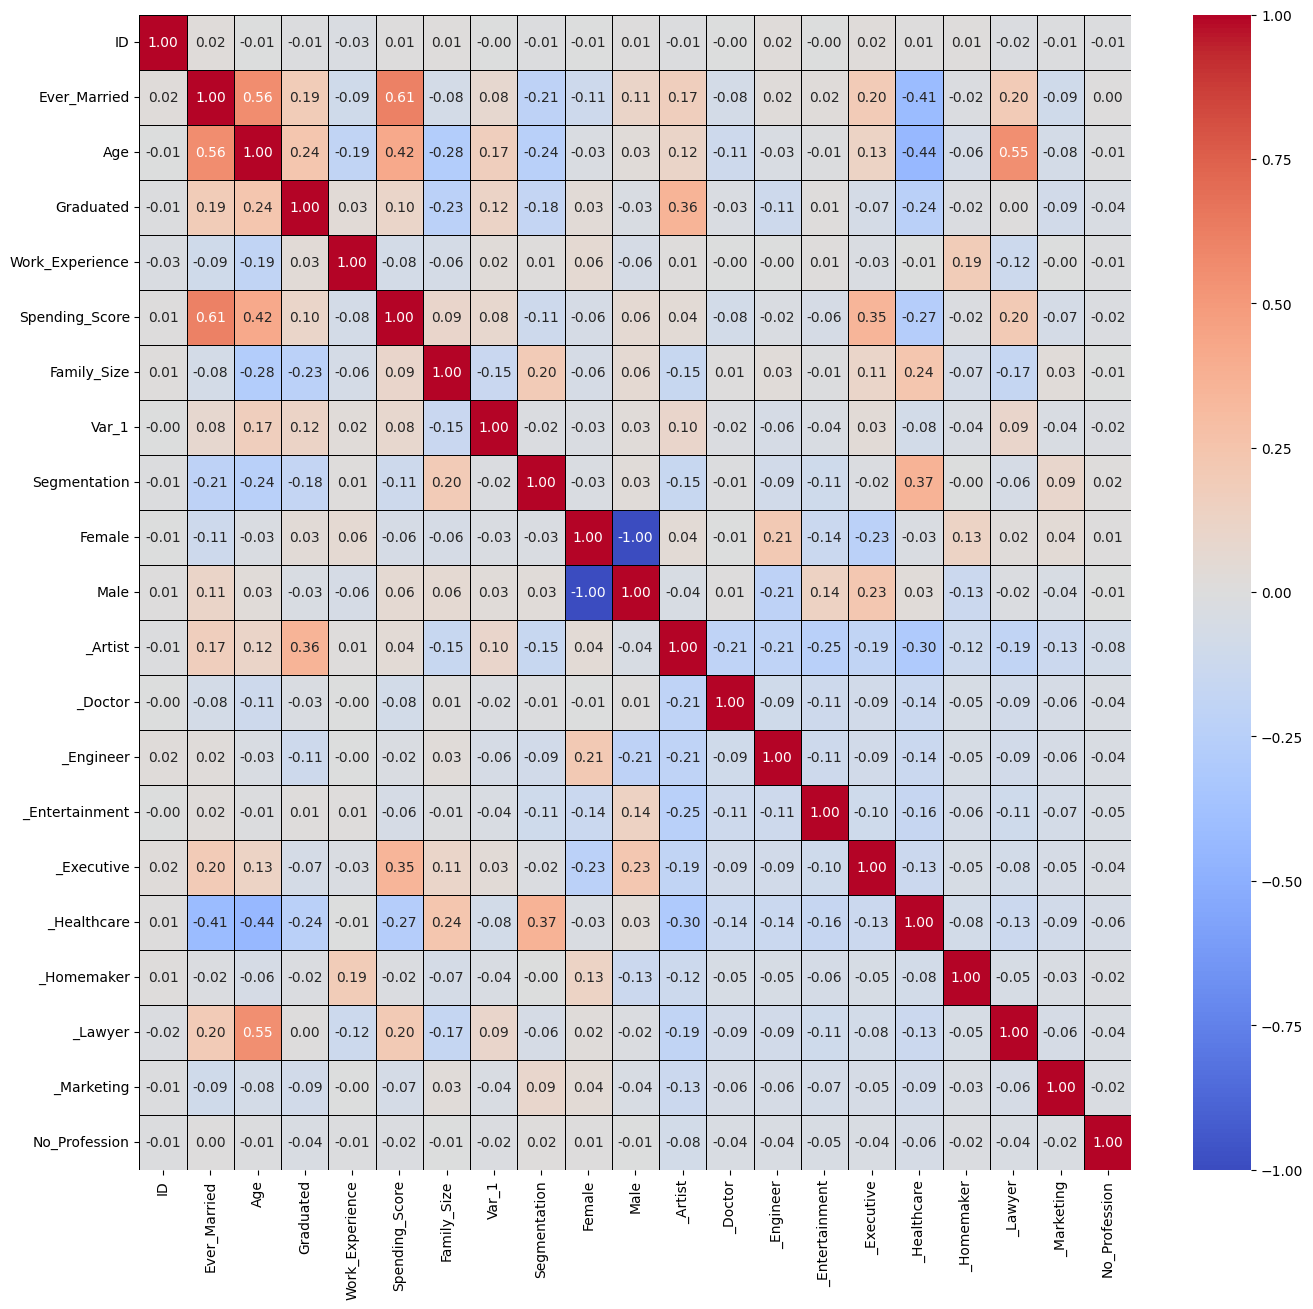

In [15]:
draw_correlation_table(df4)

> The target attribute correlation details:
* High correlation with Healthcare profession with 0.37
* Lowest correlation with Homemaker profession with 0.00

In [16]:
df4.isna().sum()

ID                   0
Ever_Married         0
Age                  0
Graduated            0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
Female               0
Male                 0
_Artist              0
_Doctor              0
_Engineer            0
_Entertainment       0
_Executive           0
_Healthcare          0
_Homemaker           0
_Lawyer              0
_Marketing           0
No_Profession        0
dtype: int64

* Work experience has a low correlation with the target attribute, so we will remove those rows
* Family size has a moderate correlation with the target attribute, so we will fill null values with 1.0
* Var_1 has a low correlation with the target attribute, so we will remove those rows

In [17]:
df5 = df4.dropna(subset=['Work_Experience', 'Var_1']).fillna({'Family_Size': 1})
df5.isna().sum()

ID                 0
Ever_Married       0
Age                0
Graduated          0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
Female             0
Male               0
_Artist            0
_Doctor            0
_Engineer          0
_Entertainment     0
_Executive         0
_Healthcare        0
_Homemaker         0
_Lawyer            0
_Marketing         0
No_Profession      0
dtype: int64

In [18]:
df5.head()

,ID,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Female,...,_Artist,_Doctor,_Engineer,_Entertainment,_Executive,_Healthcare,_Homemaker,_Lawyer,_Marketing,No_Profession
0,462809,0,22,0,1.0,0,4.0,4.0,4,0,...,0,0,0,0,0,1,0,0,0,0
2,466315,1,67,1,1.0,0,1.0,6.0,2,1,...,0,0,1,0,0,0,0,0,0,0
3,461735,1,67,1,0.0,2,2.0,6.0,2,0,...,0,0,0,0,0,0,0,1,0,0
5,461319,1,56,0,0.0,1,2.0,6.0,3,0,...,1,0,0,0,0,0,0,0,0,0
6,460156,0,32,1,1.0,0,3.0,6.0,3,0,...,0,0,0,0,0,1,0,0,0,0


## Training

### K-Nearest Neighbour (KNN)

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [24]:
X = df5.drop(columns=['Segmentation'])
y = df5['Segmentation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.4195121951219512
Confusion Matrix:
 [[145  94  59  78]
 [ 93  88  75  50]
 [ 80  89 155  32]
 [ 77  65  41 214]]


### Support Vector Classification (SVC)

In [21]:
from sklearn.svm import SVC

In [ ]:
X = df5.drop(columns=['Segmentation'])
y = df5['Segmentation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svc = SVC(decision_function_shape='ovo', kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))